Root Mean Squared Error (RMSE): 832.96
Mean Absolute Error (MAE): 697.38


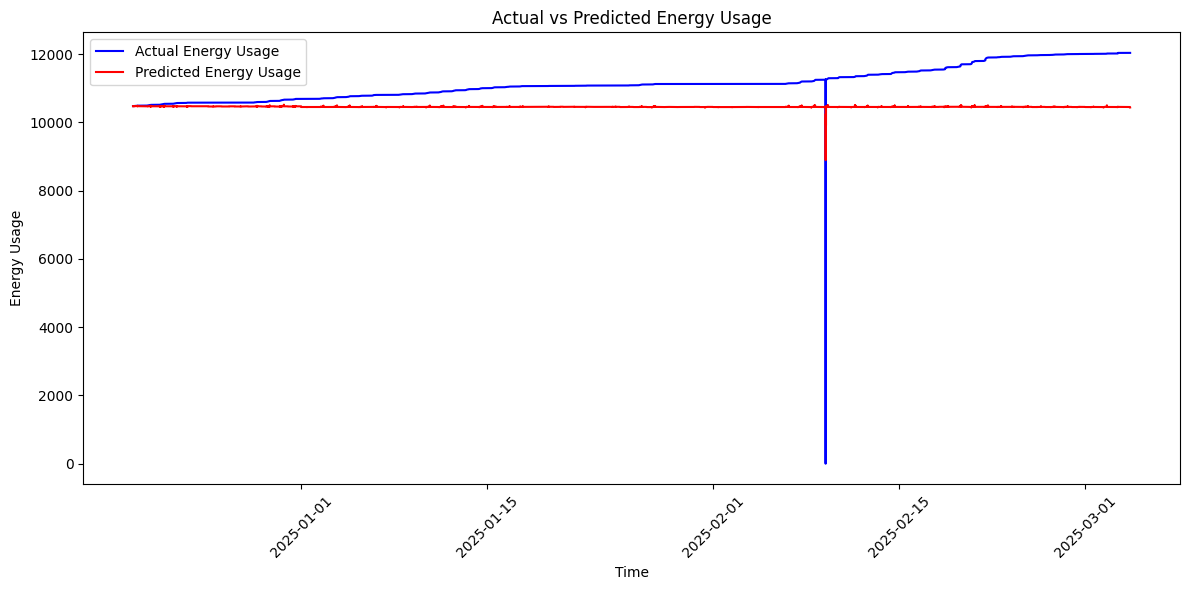

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Load your dataset (replace 'energy_data.csv' with your file)
# Assuming columns: time, energy, power
data = pd.read_csv('/Users/kashmithnisakya/Developer/Data_Science/Energy-Prediction-System/ml/data/processed/china_mill_data_2025_03_04_09_30_30.csv', parse_dates=['time'])
data.set_index('time', inplace=True)

# For this sample, sort by time (in case data isn’t chronological)
data.sort_index(inplace=True)

# 2. Feature Engineering: Create lagged features and time-based features
def create_features(df, target_col, lag_steps=10):
    df = df.copy()
    # Lagged energy usage (e.g., past 10 time steps)
    for i in range(1, lag_steps + 1):
        df[f'lag_{i}'] = df[target_col].shift(i)
    # Time-based features from the index
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['second'] = df.index.second
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    # Optional: Add power as a feature
    df['power'] = df['power']
    return df

# Apply feature engineering (targeting 'energy')
data = create_features(data, 'energy', lag_steps=10)
data.dropna(inplace=True)  # Remove rows with NaN due to lagging

# 3. Define features (X) and target (y)
X = data.drop(columns=['energy'])  # Include 'power' as a feature
y = data['energy']

# 4. Split into training and testing sets (80% train, 20% test, no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 5. Initialize and train the XGBoost model
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

# 6. Make predictions
y_pred = model.predict(X_test)

# 7. Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# 8. Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Energy Usage', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Energy Usage', color='red')
plt.xlabel('Time')
plt.ylabel('Energy Usage')
plt.title('Actual vs Predicted Energy Usage')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 9. (Optional) Save the model
model.save_model('xgboost_energy_model.json')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load and preprocess the dataset
def load_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    # Handle missing values
    df['energy'] = df['energy'].interpolate(method='linear')
    return df

# Feature engineering
def create_features(df, lags=[1, 24, 168]):  # Lags for 1 hour, 1 day, 1 week (assuming hourly data)
    df_features = df.copy()
    
    # Time-based features
    df_features['hour'] = df_features.index.hour
    df_features['day'] = df_features.index.day
    df_features['month'] = df_features.index.month
    df_features['dayofweek'] = df_features.index.dayofweek
    
    # Lagged features
    for lag in lags:
        df_features[f'lag_{lag}'] = df_features['energy'].shift(lag)
    
    # Rolling mean
    df_features['rolling_mean_24h'] = df_features['energy'].rolling(window=24).mean()
    
    # Drop NaN values created by lagging/rolling
    df_features = df_features.dropna()
    return df_features

# Main function for prediction pipeline
def energy_prediction_pipeline(file_path, test_size=0.2, n_estimators=100):
    # Load and preprocess data
    df = load_data(file_path)
    df_features = create_features(df)
    
    # Define features and target
    X = df_features.drop('energy', axis=1)
    y = df_features['energy']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    
    # Train XGBoost model
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f'Train RMSE: {train_rmse:.2f}')
    print(f'Test RMSE: {test_rmse:.2f}')
    
    # Plot predictions
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, y_pred_test, label='Predicted')
    plt.title('Energy Consumption Prediction (XGBoost)')
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.legend()
    plt.savefig('xgboost_predictions.png')
    
    # Feature importance
    feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    feature_importance.plot(kind='bar')
    plt.title('Feature Importance')
    plt.savefig('feature_importance.png')
    
    return model

# Example usage
if __name__ == '__main__':
    file_path = 'energy_data.csv'  # Replace with your actual file path
    model = energy_prediction_pipeline(file_path)